# Cat and Dog classifier application

By 
Nattapat Yuvasuta ID: 59070501028 <br>
Niti Buesamae ID: 590705010147

In [11]:
import keras
import cv2,os,re
from skimage.transform import resize
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import mnist
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.applications import vgg16

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

## 1. Pre - train model
Using pre-trained model from image net 

In [3]:
IMG_WIDTH, IMG_HEIGHT = 150, 150
TRAIN_DATA_DIR = 'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/data_test/training'
VALIDATION_DATA_DIR = 'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/data_test/validation'
TEST_DATA_DIR = 'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/data_test/testing'
TEST =  'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/data_test/test'
NB_TRAIN_SAMPLES = 2000
NB_VALIDATION_SAMPLES = 800
NB_EPOCH = 50

### 1.1. Pre-process data 
Using image generator from keras.preprocessing

In [4]:
train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [5]:
val_datagen = image.ImageDataGenerator(rescale=1./255)

In [6]:
test_datagen = image.ImageDataGenerator(rescale=1./255)

### 1.2. Load data

Load image by using flow_from_directory function 

In [7]:
train_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=32,
        class_mode='categorical')

Found 18000 images belonging to 2 classes.


In [8]:
validation_generator = val_datagen.flow_from_directory(
        VALIDATION_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=32,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
        TEST_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=32,
        class_mode='categorical')

Found 5000 images belonging to 2 classes.


In [10]:
test_array = []
for img in os.listdir(TEST):
        path_r = os.path.join(TEST,img)
        test_array.append(cv2.resize((cv2.imread(path_r)),
                                 (IMG_WIDTH,IMG_HEIGHT))
                        )

In [11]:
test =  np.array(test_array)

### 1.3. Build model
using vgg16 pre-train model

In [34]:
model_vgg16_conv = vgg16.VGG16(weights='imagenet', include_top=False)

In [35]:
model_vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

remove input layer and feeze model

In [36]:
for layer in model_vgg16_conv.layers[:-4]:
    print(layer)

In [37]:
for layer in model_vgg16_conv.layers[:-4]:
    layer.trainable = False

Use pretain model by using 256 nodes in dense layer because we had used 128 nodes in dense layer but it doesn't give a desire result so maybe double it from 128 to 256 node may help and it result in 0.9 precision

In [38]:
input = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = model_vgg16_conv(input)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation='softmax')(x)
model = Model(input=input, output=x)

C:\Users\Nz-zero\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Use pre-train model and add hidden layer with 256 node and output layer

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 16,812,610
Trainable params: 9,177,346
Non-trainable params: 7,635,264
_________________________________________________________

In [40]:
model.compile(loss='binary_crossentropy',
        optimizer=SGD(lr=1e-4, momentum=0.9),
        metrics=['accuracy'])

### 1.4. Train the model
Using fit_generator as ImageDataGenerator class it use real time data augmentation

In [16]:
history = model.fit_generator(
        train_generator,
        samples_per_epoch=NB_TRAIN_SAMPLES,
        nb_epoch=NB_EPOCH,
        validation_data=(X_val,y_val),
        nb_val_samples=NB_VALIDATION_SAMPLES)

C:\Users\Nz-zero\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\Nz-zero\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., steps_per_epoch=62, epochs=50, validation_steps=800)`
  


Epoch 1/50
62/62 [==============================] - 140s 2s/step - loss: 0.6754 - acc: 0.6275 - val_loss: 0.4800 - val_acc: 0.8099
Epoch 2/50
62/62 [==============================] - 149s 2s/step - loss: 0.4854 - acc: 0.7606 - val_loss: 0.4026 - val_acc: 0.8256
Epoch 3/50
62/62 [==============================] - 152s 2s/step - loss: 0.4323 - acc: 0.8049 - val_loss: 0.3348 - val_acc: 0.8645
Epoch 4/50
62/62 [==============================] - 156s 3s/step - loss: 0.3451 - acc: 0.8478 - val_loss: 0.2898 - val_acc: 0.8816
Epoch 5/50
62/62 [==============================] - 157s 3s/step - loss: 0.3614 - acc: 0.8402 - val_loss: 0.2758 - val_acc: 0.8807
Epoch 6/50
62/62 [==============================] - 162s 3s/step - loss: 0.3312 - acc: 0.8629 - val_loss: 0.2655 - val_acc: 0.8850
Epoch 7/50
62/62 [==============================] - 163s 3s/step - loss: 0.3066 - acc: 0.8740 - val_loss: 0.2486 - val_acc: 0.9023
Epoch 8/50
62/62 [==============================] - 162s 3s/step - loss: 0.3024 - a

Last train accuracy: 0.9259072580645161
Last validation accuracy: 0.943521725440806


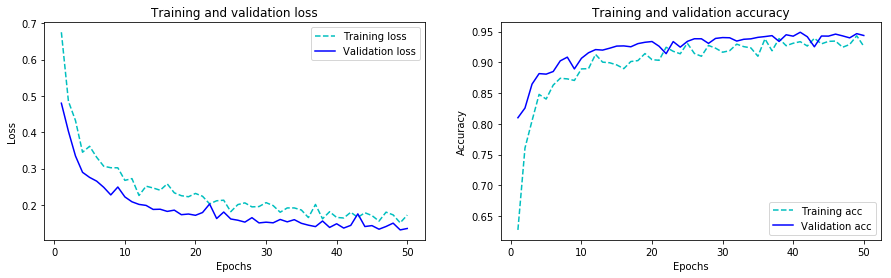

In [17]:
show_result(history)

In [ ]:
target_names = ['cat', 'dog']
print(classification_report(y_true, y_pred, target_names=target_names))

In [19]:
model.evaluate_generator(test_generator,1500)

[0.13819764044354724, 0.9416959651766281]

In [20]:
test_generator.reset()

In [21]:
len(test_generator.classes)

5000

In [22]:
pred=model.predict(test)

In [23]:
predicted_class_indices=np.argmax(pred,axis=1)

In [24]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_class_indices))

Confusion Matrix
[[2009  491]
 [  18 2482]]


In [ ]:
target_names = ['Cats', 'Dogs']
print(classification_report(test_generator.classes, predicted_class_indices, target_names=target_names))

In [70]:
imgtester = []
imgtester.append(cv2.resize((cv2.imread('C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/test1/66.jpg')),
                 (IMG_WIDTH,IMG_HEIGHT)
                ))
imgtester.append(cv2.resize((cv2.imread('C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/test1/82.jpg')),
                 (IMG_WIDTH,IMG_HEIGHT)
                ))
imgtester.append(cv2.resize((cv2.imread('C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/test1/78.jpg')),
                 (IMG_WIDTH,IMG_HEIGHT)
                ))
imgtester.append(cv2.resize((cv2.imread('C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/test1/84.jpg')),
                 (IMG_WIDTH,IMG_HEIGHT)
                ))
imgtester = np.array(imgtester)

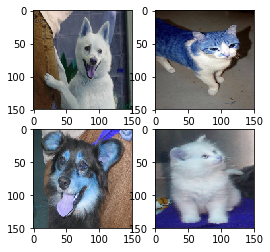

In [83]:
fig, ax = plt.subplots(2,2,figsize=(4,4))
ax[0,0].imshow(imgtester[0])
ax[0,1].imshow(imgtester[1])
ax[1,0].imshow(imgtester[2])
ax[1,1].imshow(imgtester[3])
plt.show()

In [91]:
predict = model.predict(imgtester)
res = predict.argmax(axis=-1)
for i in res :
    if i == 1 :
        print('Dog')
    else:
        print('Cat')

Dog
Cat
Dog
Dog


## 2. Using our model

### 2.1. Load Data

load image data by using cv2

In [12]:
img_test = cv2.imread('C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/dataset\cat\cat.0.jpg')

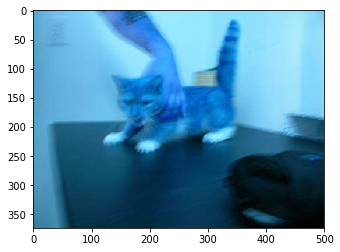

In [13]:
plt.imshow(img_test)
plt.show()

In [14]:
import matplotlib.pyplot as plt
img_array = []
IMG_SIZE = 150
TRAIN_DIR = 'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/train'
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
for img in os.listdir(TRAIN_DIR):
        path_r = os.path.join(TRAIN_DIR,img)
        img_array.append(cv2.resize((cv2.imread(path_r,0)),
                                 (IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_CUBIC))
                        

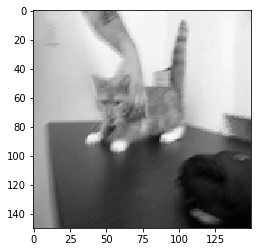

In [16]:
plt.imshow(img_array[0], cmap = 'gray')
plt.show()

### 2.2. Preprocess Data

In [17]:
def prepare_data(img_list):
    y=[] #labels
    for j in img_list:
        if 'cat' in j:
            y.append(0)
        elif 'dog' in j:
            y.append(1)
    return y

In [18]:
def preprocess(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1).astype('float32')/255.
    return data

In [19]:
X_train =  np.array(img_array)
y_train = prepare_data(train_images)

In [20]:
len(X_train)

25000

In [21]:
X_train[0]

array([[167, 172, 173, ..., 209, 206, 204],
       [167, 172, 173, ..., 209, 207, 204],
       [167, 172, 173, ..., 211, 208, 206],
       ...,
       [126, 127, 128, ...,   3,   3,   2],
       [125, 126, 129, ...,   2,   2,   2],
       [123, 124, 127, ...,   2,   2,   2]], dtype=uint8)

In [22]:
X_train = preprocess(X_train)

In [23]:
print(len(X_train),len(y_train))

25000 25000


In [24]:
#prepare Test SET
X_train

array([[[[0.654902  ],
         [0.6745098 ],
         [0.6784314 ],
         ...,
         [0.81960785],
         [0.80784315],
         [0.8       ]],

        [[0.654902  ],
         [0.6745098 ],
         [0.6784314 ],
         ...,
         [0.81960785],
         [0.8117647 ],
         [0.8       ]],

        [[0.654902  ],
         [0.6745098 ],
         [0.6784314 ],
         ...,
         [0.827451  ],
         [0.8156863 ],
         [0.80784315]],

        ...,

        [[0.49411765],
         [0.49803922],
         [0.5019608 ],
         ...,
         [0.01176471],
         [0.01176471],
         [0.00784314]],

        [[0.49019608],
         [0.49411765],
         [0.5058824 ],
         ...,
         [0.00784314],
         [0.00784314],
         [0.00784314]],

        [[0.48235294],
         [0.4862745 ],
         [0.49803922],
         ...,
         [0.00784314],
         [0.00784314],
         [0.00784314]]],


       [[[0.16470589],
         [0.17254902],
         [0.17

In [25]:
y_train

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


### 2.3.  Build a convolutional neural network 

#### Use simple cnn structure as base model
Give us a decent result, buit still not achieve our goal

In [7]:
cnn = models.Sequential()

cnn.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn.add(layers.Dense(256,activation='relu',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn.add(layers.Dropout(0.5,name='dropout_2'))
cnn.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))
cnn.compile(optimizer='adam',
            loss = 'sparse_categorical_crossentropy',
            metrics=['acc']
           )

In [8]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 75, 75, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 37, 37, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 18, 18, 64)        0         
_________________________________________________________________
fully_connect_1 (Dense)      (None, 18, 18, 256)       16640     
__________

####  Add more filter and convolutiuon layers
But seems to not work at all, may be increase layers and filters doesn't help us in this case

In [98]:
cnn2 = models.Sequential()

cnn2.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn2.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn2.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn2.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn2.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn2.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn2.add(layers.Conv2D(filters=256,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn2.add(layers.MaxPooling2D(2,2,name='max_pool_4'))

cnn2.add(layers.Dropout(0.25,name='dropout_1'))
cnn2.add(layers.Flatten())

cnn2.add(layers.Dense(256,activation='relu',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn2.add(layers.Dropout(0.5,name='dropout_2'))
cnn2.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))
cnn2.compile(optimizer='adam',
            loss = 'sparse_categorical_crossentropy',
            metrics=['acc']
           )
cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 75, 75, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 37, 37, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 18, 18, 128)       0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 18, 18, 256)       295168    
__________

#### Try new structure by using convution, convolution and pooling layers structure to see if more convolution may result in capturing more information 
Give us a better bresult so we will use and improve this model by tuning it. And also 0.25 and 0.5 on dropout layers seem to not help that much, so we will use a technique called "Aggressive dropout" ( use a very large value on dropout layers) that will both reduce overfit and help on increase performance on our models.

In [53]:
cnn3 = models.Sequential()

cnn3.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3.add(layers.Dropout(0.5,name='dropout_1'))
cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(256,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3.add(layers.Dropout(0.8,name='dropout_2'))
cnn3.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

'''cnn3.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['acc']
           )'''
cnn3.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 25, 25, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 25, 25, 64)        36928     
_________________________________________________________________
conv_4 (Conv2D)              (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 12, 12, 64)        36928     
__________

#### Use rms prop as optimizier
To see if rms prop optimizier will yield a better result than sgd, but it doesn't go quite well so we will continue to stick with sgd

In [54]:
cnn3_rms = models.Sequential()

cnn3_rms.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3_rms.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_rms.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_rms.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_rms.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_rms.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_rms.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_rms.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_rms.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_rms.add(layers.Dropout(0.6,name='dropout_1'))
cnn3_rms.add(layers.Flatten())
cnn3_rms.add(layers.Dense(256,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_rms.add(layers.Dropout(0.8,name='dropout_2'))
cnn3_rms.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

'''cnn3.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['acc']
           )'''
cnn3_rms.compile(loss='sparse_categorical_crossentropy',
        optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
        metrics=['acc'])
cnn3_rms.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 25, 25, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 25, 25, 64)        36928     
_________________________________________________________________
conv_4 (Conv2D)              (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 12, 12, 64)        36928     
__________

### Improved generation of cnn3 network
on previous generation our model overfit very quickly so from now on we will increase drop out layers to 0.7 from 0.5 in first drop out layers

#### First hypothesis: Increase a number of filter on each layers
Change a number of filters in each layers to see if it affects our model (cnn3 use constant number of filter with 64 filters on each layers) which result in a very good result

In [62]:
cnn3_imp = models.Sequential()

cnn3_imp.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3_imp.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_imp.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp.add(layers.Dropout(0.7,name='dropout_1'))
cnn3_imp.add(layers.Flatten())
cnn3_imp.add(layers.Dense(256,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp.add(layers.Dropout(0.8,name='dropout_2'))
cnn3_imp.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

cnn3_imp.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 25, 25, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 25, 25, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 12, 12, 128)       73856     
__________

#### Second hypothesis: Increase number of filters on single layer 
Maybe increase filters will make model capture an important details before going to dense layers but in truth it worsen the model.

In [65]:
cnn3_imp_1 = models.Sequential()

cnn3_imp_1.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3_imp_1.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_imp_1.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp_1.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp_1.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp_1.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp_1.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp_1.add(layers.Conv2D(filters=256,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp_1.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp_1.add(layers.Dropout(0.7,name='dropout_1'))
cnn3_imp_1.add(layers.Flatten())
cnn3_imp_1.add(layers.Dense(256,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp_1.add(layers.Dropout(0.8,name='dropout_2'))
cnn3_imp_1.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

cnn3_imp_1.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 25, 25, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 25, 25, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 12, 12, 128)       0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 12, 12, 128)       147584    
__________

#### Third hypothesis: increase  a value of dropout
If aggressive dropout works, then maybe increase dropout will give a better result. But it made a model perform a little worst but still good than increase a number of filters.

In [68]:
cnn3_imp_2 = models.Sequential()

cnn3_imp_2.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3_imp_2.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_imp_2.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp_2.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp_2.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp_2.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp_2.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp_2.add(layers.Conv2D(filters=256,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp_2.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp_2.add(layers.Dropout(0.8,name='dropout_1'))
cnn3_imp_2.add(layers.Flatten())
cnn3_imp_2.add(layers.Dense(256,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp_2.add(layers.Dropout(0.8,name='dropout_2'))
cnn3_imp_2.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

'''cnn3.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['acc']
           )'''
cnn3_imp_2.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 25, 25, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 25, 25, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 12, 12, 128)       73856     
__________

#### Fourth hypothesis: Increase even more dropout value and decrease number of node in dense layer
What if increase dropout does works but using a value of 0.8 is not enough, but it turn out to be more poorly performance.

In [79]:
cnn3_imp_3 = models.Sequential()

cnn3_imp_3.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3_imp_3.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_imp_3.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp_3.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp_3.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp_3.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp_3.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp_3.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp_3.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp_3.add(layers.Dropout(0.8,name='dropout_1'))
cnn3_imp_3.add(layers.Flatten())
cnn3_imp_3.add(layers.Dense(128,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp_3.add(layers.Dropout(0.9,name='dropout_3'))
cnn3_imp_3.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

'''cnn3.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['acc']
           )'''
cnn3_imp_3.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 25, 25, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 25, 25, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 12, 12, 128)       73856     
__________

#### Fifth hypothesis: Decrease number of filters and decrease number of node in dense layer
So increase too much dropout and increase a number of filter seem to not be our answer, so we use dropout and filter values of cnn3_imp which is the best one and decrease its filter value on each layer down by a half for each layer.

In [76]:
cnn3_imp_4 = models.Sequential()

cnn3_imp_4.add(layers.Conv2D(filters=16,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3_imp_4.add(layers.Conv2D(filters=16,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_imp_4.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp_4.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp_4.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp_4.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp_4.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp_4.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp_4.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp_4.add(layers.Dropout(0.7,name='dropout_1'))
cnn3_imp_4.add(layers.Flatten())
cnn3_imp_4.add(layers.Dense(128,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp_4.add(layers.Dropout(0.8,name='dropout_2'))
cnn3_imp_4.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

cnn3_imp_4.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 75, 75, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 75, 75, 32)        4640      
_________________________________________________________________
conv_4 (Conv2D)              (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 37, 37, 32)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 37, 37, 64)        18496     
__________

#### Sixth hypothesis: Remove one dropout layer
Just to see if it does perform better, but the answer is no.

In [68]:
cnn3_imp_5 = models.Sequential()

cnn3_imp_5.add(layers.Conv2D(filters=16,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3_imp_5.add(layers.Conv2D(filters=16,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_imp_5.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp_5.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp_5.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp_5.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp_5.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp_5.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp_5.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp_5.add(layers.Flatten())
cnn3_imp_5.add(layers.Dense(256,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp_5.add(layers.Dropout(0.8,name='dropout_1'))
cnn3_imp_5.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

'''cnn3.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['acc']
           )'''
cnn3_imp_5.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 75, 75, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 75, 75, 32)        4640      
_________________________________________________________________
conv_4 (Conv2D)              (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 37, 37, 32)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 37, 37, 64)        18496     
__________

#### Seventh hypothesis: Increase more convolution layer
What if we add 1 more convolution layers? The result is the performance is worsen, maybe because it captured too much the non-important feature. 

In [86]:
cnn3_imp_6 = models.Sequential()

cnn3_imp_6.add(layers.Conv2D(filters=8,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_0'))
cnn3_imp_6.add(layers.Conv2D(filters=16,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(2,2,1,),
                name = 'conv_2'))
cnn3_imp_6.add(layers.Conv2D(filters=16,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp_6.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp_6.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp_6.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp_6.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp_6.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp_6.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_7'))
cnn3_imp_6.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp_6.add(layers.Dropout(0.7,name='dropout_1'))
cnn3_imp_6.add(layers.Flatten())
cnn3_imp_6.add(layers.Dense(128,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp_6.add(layers.Dropout(0.8,name='dropout_2'))
cnn3_imp_6.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

'''cnn3.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['acc']
           )'''
cnn3_imp_6.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 150, 150, 8)       80        
_________________________________________________________________
conv_2 (Conv2D)              (None, 150, 150, 16)      1168      
_________________________________________________________________
conv_3 (Conv2D)              (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 75, 75, 16)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 75, 75, 32)        4640      
_________________________________________________________________
conv_5 (Conv2D)              (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 37, 37, 32)        0         
__________

#### Eighth hypothesis :  Remove 1 convolution layer
What if the first layer doesn't have much meaningful information? Turns out that it doesn't work.

In [89]:
cnn3_imp_7 = models.Sequential()

cnn3_imp_7.add(layers.Conv2D(filters=16,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3_imp_7.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp_7.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp_7.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp_7.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp_7.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp_7.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp_7.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp_7.add(layers.Dropout(0.7,name='dropout_1'))
cnn3_imp_7.add(layers.Flatten())
cnn3_imp_7.add(layers.Dense(128,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp_7.add(layers.Dropout(0.8,name='dropout_2'))
cnn3_imp_7.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

cnn3_imp_7.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp_7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 75, 75, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 75, 75, 32)        4640      
_________________________________________________________________
conv_4 (Conv2D)              (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 37, 37, 32)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 37, 37, 64)        18496     
_________________________________________________________________
conv_6 (Conv2D)              (None, 37, 37, 64)        36928     
__________

So it seems that ccn3_imp_4 works best, then we are back to using it but using a technique called "mini batch" so that a model could capture more meaningful feature by decrease a batch size by a half which result in achieving 0.9 precision which is our goal

In [92]:
cnn3_imp_4_1 = models.Sequential()

cnn3_imp_4_1.add(layers.Conv2D(filters=16,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_SIZE,IMG_SIZE,1,),
                name = 'conv_1'))
cnn3_imp_4_1.add(layers.Conv2D(filters=16,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_imp_4_1.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp_4_1.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp_4_1.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp_4_1.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp_4_1.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp_4_1.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp_4_1.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp_4_1.add(layers.Dropout(0.7,name='dropout_1'))
cnn3_imp_4_1.add(layers.Flatten())
cnn3_imp_4_1.add(layers.Dense(128,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp_4_1.add(layers.Dropout(0.8,name='dropout_2'))
cnn3_imp_4_1.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

cnn3_imp_4_1.compile(loss='sparse_categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp_4_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 75, 75, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 75, 75, 32)        4640      
_________________________________________________________________
conv_4 (Conv2D)              (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 37, 37, 32)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 37, 37, 64)        18496     
__________

In [232]:
cnn3_1 = models.Sequential()

cnn3_1.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_WIDTH,IMG_HEIGHT,3,),
                name = 'conv_1'))
cnn3_1.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_1.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_1.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_1.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_1.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_1.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_1.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_1.add(layers.MaxPooling2D(2,2,name='max_pool_3'))


cnn3_1.add(layers.Dropout(0.5,name='dropout_1'))
cnn3_1.add(layers.Flatten())
cnn3_1.add(layers.Dense(256,activation='relu',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_1.add(layers.Dropout(0.8,name='dropout_2'))
cnn3_1.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

cnn3_1.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['acc']
           )
cnn3_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 75, 75, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 75, 75, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 37, 37, 64)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 37, 37, 128)       73856     
__________

In [ ]:
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, 
                  weights='imagenet',
                  input_shape=(50,50,3))

In [ ]:
vgg.summary()

In [ ]:
vgg.trainable = False

In [ ]:
new_cnn = models.Sequential()
new_cnn.add(vgg)
new_cnn.add(layers.Dense(256,activation='relu'))
new_cnn.add(layers.Dropout(0.2))
new_cnn.add(layers.Dense(2,activation='softmax',name='output'))
new_cnn.compile(optimizer='adam',
            loss = 'sparse_categorical_crossentropy',
            metrics=['acc']
           )
new_cnn.summary()

### Traing with train_generator

Test function Data augmentaion with model 3.1

In [143]:
history_test = cnn3_1.fit_generator(train_generator,
                    samples_per_epoch=NB_TRAIN_SAMPLES, 
                    nb_epoch=NB_EPOCH,
                    validation_data=validation_generator,
                    nb_val_samples=NB_VALIDATION_SAMPLES)


C:\Users\Nz-zero\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
C:\Users\Nz-zero\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., steps_per_epoch=62, epochs=50, validation_steps=800)`
  """


Epoch 1/50
62/62 [==============================] - 89s 1s/step - loss: 0.6817 - acc: 0.5781 - val_loss: 0.6691 - val_acc: 0.5543
Epoch 2/50
62/62 [==============================] - 90s 1s/step - loss: 0.6607 - acc: 0.6210 - val_loss: 0.6302 - val_acc: 0.6275
Epoch 3/50
62/62 [==============================] - 90s 1s/step - loss: 0.6470 - acc: 0.6104 - val_loss: 0.6049 - val_acc: 0.7093
Epoch 4/50
62/62 [==============================] - 94s 2s/step - loss: 0.6248 - acc: 0.6552 - val_loss: 0.6078 - val_acc: 0.6691
Epoch 5/50
62/62 [==============================] - 93s 1s/step - loss: 0.6354 - acc: 0.6346 - val_loss: 0.6682 - val_acc: 0.6094
Epoch 6/50
62/62 [==============================] - 95s 2s/step - loss: 0.6325 - acc: 0.6573 - val_loss: 0.5659 - val_acc: 0.7286
Epoch 7/50
62/62 [==============================] - 92s 1s/step - loss: 0.6110 - acc: 0.6673 - val_loss: 0.5661 - val_acc: 0.7116
Epoch 8/50
62/62 [==============================] - 94s 2s/step - loss: 0.5931 - acc: 0.68

Last train accuracy: 0.8412298387096774
Last validation accuracy: 0.8481411468178954


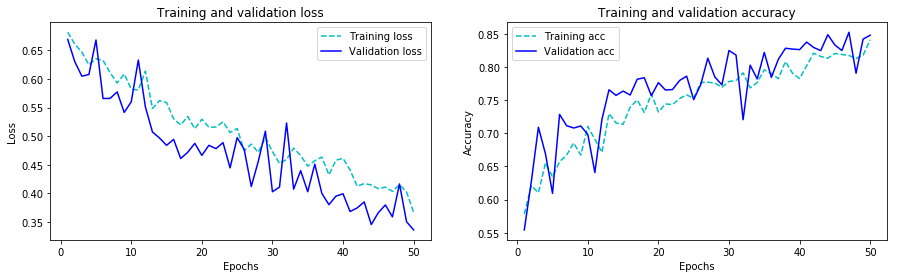

In [144]:
show_result(history_test)

In [ ]:
pred3_1=cnn3_1.predict(test)
predicted3_1=np.argmax(pred3_1,axis=1)

In [147]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted3_1))
target_names = ['Cats', 'Dogs']
print(classification_report(test_generator.classes, predicted3_1, target_names=target_names))

Confusion Matrix
[[2137  363]
 [1248 1252]]
             precision    recall  f1-score   support

       Cats       0.63      0.85      0.73      2500
       Dogs       0.78      0.50      0.61      2500

avg / total       0.70      0.68      0.67      5000



### 4. Trainig CNN Model 

split data to train validation and testing set

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,stratify = y_train, random_state=0)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.1,stratify = y_train, random_state=0)

In [ ]:
history0 = cnn.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

In [ ]:
show_result(history)

In [ ]:
history_pretrain = new_cnn.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

In [ ]:
history1 = cnn1.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

In [ ]:
show_result(history1)

In [ ]:
history1_1 = cnn.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_val,y_val))
show_result(history1_1)

In [ ]:
evaluation_report(cnn,X_test,y_test)

In [ ]:
evaluation_report(cnn1,X_test,y_test)

use data augmentation configuration 

In [ ]:
#use data augmentation configuration 
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]
BATCH_SIZE = 32

Define a generator for train set and test set

In [ ]:
# Define a generator for train set and test set

train_datagen = image.ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False)

test_datagen = image.ImageDataGenerator(rescale=1./255)

Create an Iterator object. 

In [ ]:
# Create an Iterator object. 
train_generator = train_datagen.flow(X_train,y_train,
                                    batch_size = BATCH_SIZE,
                                    seed=0)

validate_generator = test_datagen.flow(X_val,y_val,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False)

In [ ]:
history2 = cnn.fit_generator(train_generator,
                    steps_per_epoch=len(X_train) / 32, 
                    epochs=20,
                    validation_data=(X_val,y_val))

show_result(history2)

In [ ]:
history3 = cnn1.fit_generator(train_generator,
                    steps_per_epoch=len(X_train) / 32, 
                    epochs=20,
                    validation_data=(X_val,y_val))

show_result(history3)

In [ ]:
evaluation_report(cnn,X_test,y_test)

In [ ]:
history1_2 = cnn2.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))
show_result(history1_2)

In [ ]:
evaluation_report(cnn2,X_test,y_test)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 13s 633us/step - loss: 0.7539 - acc: 0.5039 - val_loss: 0.6934 - val_acc: 0.5064
Epoch 2/50
20250/20250 [==============================] - 12s 580us/step - loss: 0.6943 - acc: 0.5175 - val_loss: 0.6947 - val_acc: 0.5028
Epoch 3/50
20250/20250 [==============================] - 12s 583us/step - loss: 0.6897 - acc: 0.5358 - val_loss: 0.6820 - val_acc: 0.5824
Epoch 4/50
20250/20250 [==============================] - 12s 576us/step - loss: 0.6864 - acc: 0.5536 - val_loss: 0.6775 - val_acc: 0.5872
Epoch 5/50
20250/20250 [==============================] - 12s 578us/step - loss: 0.6794 - acc: 0.5725 - val_loss: 0.6997 - val_acc: 0.5440
Epoch 6/50
20250/20250 [==============================] - 12s 590us/step - loss: 0.6785 - acc: 0.5702 - val_loss: 0.7077 - val_acc: 0.5048
Epoch 7/50
20250/20250 [==============================] - 12s 603us/step - loss: 0.6723 - acc: 0.5867 - val_loss: 0.6

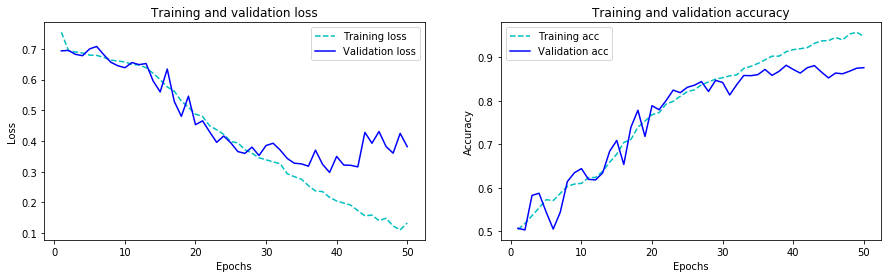

In [55]:
history1_3 = cnn3.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history1_3)

In [56]:
evaluation_report(cnn3,X_test,y_test)

[[1002  123]
 [ 171  954]]
             precision    recall  f1-score   support

          0       0.85      0.89      0.87      1125
          1       0.89      0.85      0.87      1125

avg / total       0.87      0.87      0.87      2250

Loss: 0.38522437278429666 Accuracy: 0.8693333332273695


array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 14s 685us/step - loss: 0.7625 - acc: 0.5088 - val_loss: 0.6870 - val_acc: 0.5596
Epoch 2/50
20250/20250 [==============================] - 13s 630us/step - loss: 0.6856 - acc: 0.5637 - val_loss: 0.6800 - val_acc: 0.5928
Epoch 3/50
20250/20250 [==============================] - 13s 633us/step - loss: 0.6539 - acc: 0.6240 - val_loss: 0.7202 - val_acc: 0.6016
Epoch 4/50
20250/20250 [==============================] - 13s 635us/step - loss: 0.6144 - acc: 0.6748 - val_loss: 0.6122 - val_acc: 0.6488
Epoch 5/50
20250/20250 [==============================] - 13s 629us/step - loss: 0.5651 - acc: 0.7167 - val_loss: 0.6327 - val_acc: 0.6696
Epoch 6/50
20250/20250 [==============================] - 13s 630us/step - loss: 0.5177 - acc: 0.7524 - val_loss: 0.4743 - val_acc: 0.7740
Epoch 7/50
20250/20250 [==============================] - 13s 637us/step - loss: 0.4736 - acc: 0.7828 - val_loss: 0.4

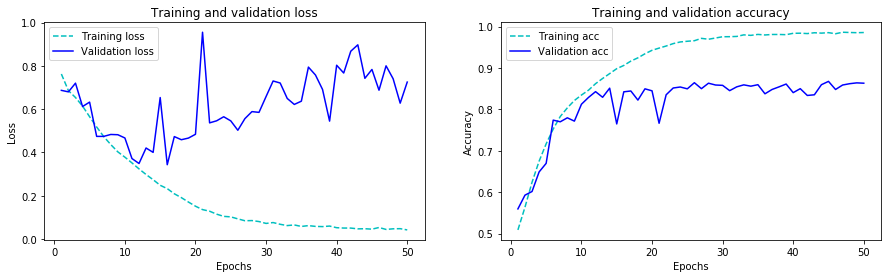

In [57]:
history1_4 = cnn3_rms.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history1_4)

In [58]:
evaluation_report(cnn3_rms,X_test,y_test)

[[974 151]
 [155 970]]
             precision    recall  f1-score   support

          0       0.86      0.87      0.86      1125
          1       0.87      0.86      0.86      1125

avg / total       0.86      0.86      0.86      2250

Loss: 0.7788553809324901 Accuracy: 0.8639999998940362


array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 11s 564us/step - loss: 0.7491 - acc: 0.5049 - val_loss: 0.6892 - val_acc: 0.5252
Epoch 2/50
20250/20250 [==============================] - 10s 488us/step - loss: 0.6901 - acc: 0.5391 - val_loss: 0.6846 - val_acc: 0.5344
Epoch 3/50
20250/20250 [==============================] - 10s 489us/step - loss: 0.6803 - acc: 0.5666 - val_loss: 0.6702 - val_acc: 0.5884
Epoch 4/50
20250/20250 [==============================] - 10s 491us/step - loss: 0.6699 - acc: 0.5908 - val_loss: 0.6534 - val_acc: 0.6176
Epoch 5/50
20250/20250 [==============================] - 10s 491us/step - loss: 0.6680 - acc: 0.5948 - val_loss: 0.6474 - val_acc: 0.6204
Epoch 6/50
20250/20250 [==============================] - 10s 490us/step - loss: 0.6603 - acc: 0.6014 - val_loss: 0.6459 - val_acc: 0.6296
Epoch 7/50
20250/20250 [==============================] - 10s 492us/step - loss: 0.6538 - acc: 0.6158 - val_loss: 0.6

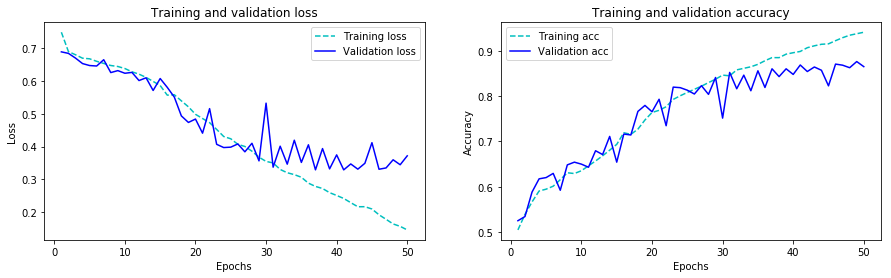

In [63]:
history5 = cnn3_imp.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history5)

In [64]:
evaluation_report(cnn3_imp,X_test,y_test)

[[1010  115]
 [ 156  969]]
             precision    recall  f1-score   support

          0       0.87      0.90      0.88      1125
          1       0.89      0.86      0.88      1125

avg / total       0.88      0.88      0.88      2250

Loss: 0.33657132040129767 Accuracy: 0.8795555556085375


array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 14s 699us/step - loss: 0.7322 - acc: 0.5126 - val_loss: 0.6933 - val_acc: 0.5024
Epoch 2/50
20250/20250 [==============================] - 12s 616us/step - loss: 0.6894 - acc: 0.5371 - val_loss: 0.6778 - val_acc: 0.5864
Epoch 3/50
20250/20250 [==============================] - 13s 624us/step - loss: 0.6808 - acc: 0.5673 - val_loss: 0.6728 - val_acc: 0.5828
Epoch 4/50
20250/20250 [==============================] - 13s 619us/step - loss: 0.6752 - acc: 0.5763 - val_loss: 0.6635 - val_acc: 0.6064
Epoch 5/50
20250/20250 [==============================] - 12s 617us/step - loss: 0.6712 - acc: 0.5893 - val_loss: 0.6616 - val_acc: 0.6184
Epoch 6/50
20250/20250 [==============================] - 12s 616us/step - loss: 0.6676 - acc: 0.5925 - val_loss: 0.6581 - val_acc: 0.6072
Epoch 7/50
20250/20250 [==============================] - 13s 619us/step - loss: 0.6626 - acc: 0.6007 - val_loss: 0.6

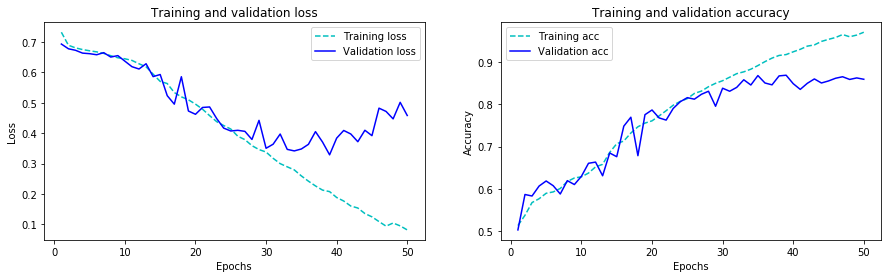

In [66]:
history6 = cnn3_imp_1.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history6)

In [67]:
evaluation_report(cnn3_imp_1,X_test,y_test)

[[ 914  211]
 [ 110 1015]]
             precision    recall  f1-score   support

          0       0.89      0.81      0.85      1125
          1       0.83      0.90      0.86      1125

avg / total       0.86      0.86      0.86      2250

Loss: 0.4774145702785916 Accuracy: 0.8573333332803514


array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 12s 608us/step - loss: 0.7456 - acc: 0.5151 - val_loss: 0.6842 - val_acc: 0.5372
Epoch 2/50
20250/20250 [==============================] - 11s 548us/step - loss: 0.6920 - acc: 0.5386 - val_loss: 0.7011 - val_acc: 0.5024
Epoch 3/50
20250/20250 [==============================] - 11s 541us/step - loss: 0.6815 - acc: 0.5654 - val_loss: 0.6671 - val_acc: 0.5896
Epoch 4/50
20250/20250 [==============================] - 11s 539us/step - loss: 0.6766 - acc: 0.5769 - val_loss: 0.6835 - val_acc: 0.5460
Epoch 5/50
20250/20250 [==============================] - 11s 539us/step - loss: 0.6723 - acc: 0.5852 - val_loss: 0.6595 - val_acc: 0.6196
Epoch 6/50
20250/20250 [==============================] - 11s 541us/step - loss: 0.6672 - acc: 0.5933 - val_loss: 0.6562 - val_acc: 0.6176
Epoch 7/50
20250/20250 [==============================] - 11s 540us/step - loss: 0.6590 - acc: 0.6097 - val_loss: 0.6

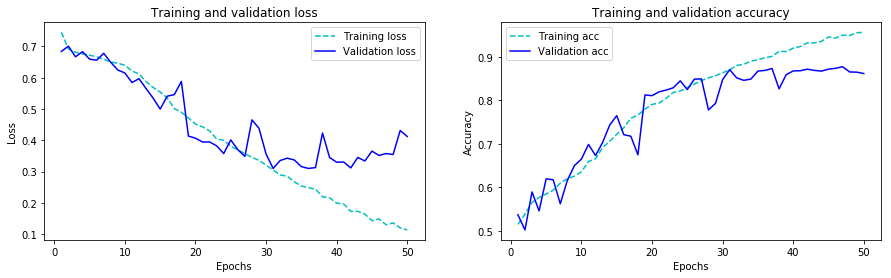

In [69]:
history7 = cnn3_imp_2.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history7)

In [70]:
evaluation_report(cnn3_imp_2,X_test,y_test)

[[ 868  257]
 [  63 1062]]
             precision    recall  f1-score   support

          0       0.93      0.77      0.84      1125
          1       0.81      0.94      0.87      1125

avg / total       0.87      0.86      0.86      2250

Loss: 0.41784267004330955 Accuracy: 0.857777777671814


array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 11s 562us/step - loss: 0.7576 - acc: 0.5022 - val_loss: 0.6929 - val_acc: 0.5128
Epoch 2/50
20250/20250 [==============================] - 10s 490us/step - loss: 0.6965 - acc: 0.4995 - val_loss: 0.6929 - val_acc: 0.5060
Epoch 3/50
20250/20250 [==============================] - 10s 490us/step - loss: 0.6935 - acc: 0.5121 - val_loss: 0.6921 - val_acc: 0.5192
Epoch 4/50
20250/20250 [==============================] - 10s 491us/step - loss: 0.6926 - acc: 0.5228 - val_loss: 0.6888 - val_acc: 0.5524
Epoch 5/50
20250/20250 [==============================] - 10s 489us/step - loss: 0.6892 - acc: 0.5409 - val_loss: 0.6812 - val_acc: 0.5892
Epoch 6/50
20250/20250 [==============================] - 10s 487us/step - loss: 0.6834 - acc: 0.5548 - val_loss: 0.6743 - val_acc: 0.5888
Epoch 7/50
20250/20250 [==============================] - 10s 487us/step - loss: 0.6809 - acc: 0.5676 - val_loss: 0.6

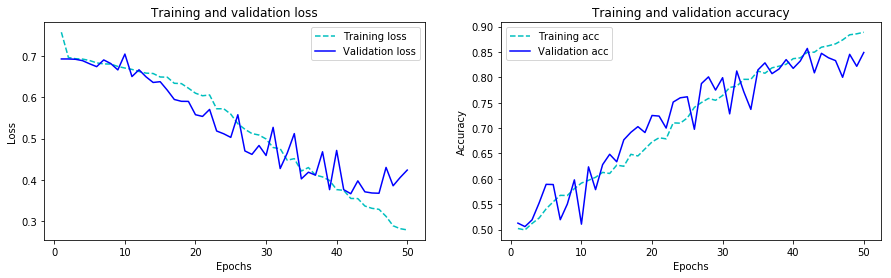

In [80]:
history8 = cnn3_imp_3.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history8)

In [81]:
evaluation_report(cnn3_imp_3,X_test,y_test)

[[993 132]
 [198 927]]
             precision    recall  f1-score   support

          0       0.83      0.88      0.86      1125
          1       0.88      0.82      0.85      1125

avg / total       0.85      0.85      0.85      2250

Loss: 0.4178478620317247 Accuracy: 0.8533333333863152


array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 43s 2ms/step - loss: 0.7239 - acc: 0.5092 - val_loss: 0.6895 - val_acc: 0.5384
Epoch 2/50
20250/20250 [==============================] - 42s 2ms/step - loss: 0.6874 - acc: 0.5492 - val_loss: 0.6949 - val_acc: 0.5036
Epoch 3/50
20250/20250 [==============================] - 43s 2ms/step - loss: 0.6797 - acc: 0.5709 - val_loss: 0.6731 - val_acc: 0.5952
Epoch 4/50
20250/20250 [==============================] - 43s 2ms/step - loss: 0.6752 - acc: 0.5820 - val_loss: 0.6593 - val_acc: 0.6152
Epoch 5/50
20250/20250 [==============================] - 43s 2ms/step - loss: 0.6598 - acc: 0.6081 - val_loss: 0.6466 - val_acc: 0.6252
Epoch 6/50
20250/20250 [==============================] - 43s 2ms/step - loss: 0.6485 - acc: 0.6207 - val_loss: 0.6290 - val_acc: 0.6616
Epoch 7/50
20250/20250 [==============================] - 43s 2ms/step - loss: 0.6362 - acc: 0.6394 - val_loss: 0.6042 - val_acc:

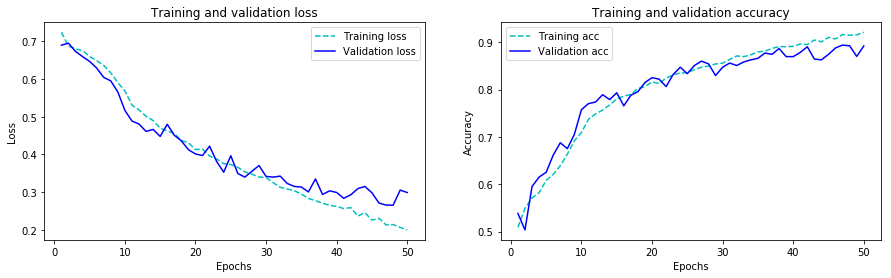

In [77]:
history9 = cnn3_imp_4.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history9)

In [78]:
evaluation_report(cnn3_imp_4,X_test,y_test)

[[1028   97]
 [ 164  961]]
             precision    recall  f1-score   support

          0       0.86      0.91      0.89      1125
          1       0.91      0.85      0.88      1125

avg / total       0.89      0.88      0.88      2250

Loss: 0.3139824041790432 Accuracy: 0.884000000052982


array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 41s 2ms/step - loss: 0.6595 - acc: 0.6075 - val_loss: 0.6404 - val_acc: 0.6348
Epoch 2/50
20250/20250 [==============================] - 40s 2ms/step - loss: 0.6438 - acc: 0.6307 - val_loss: 0.6328 - val_acc: 0.6468
Epoch 3/50
20250/20250 [==============================] - 41s 2ms/step - loss: 0.6346 - acc: 0.6434 - val_loss: 0.6187 - val_acc: 0.6716
Epoch 4/50
20250/20250 [==============================] - 42s 2ms/step - loss: 0.6075 - acc: 0.6698 - val_loss: 0.5866 - val_acc: 0.6984
Epoch 5/50
20250/20250 [==============================] - 43s 2ms/step - loss: 0.5812 - acc: 0.6998 - val_loss: 0.5612 - val_acc: 0.7080
Epoch 6/50
20250/20250 [==============================] - 43s 2ms/step - loss: 0.5522 - acc: 0.7215 - val_loss: 0.5269 - val_acc: 0.7416
Epoch 7/50
20250/20250 [==============================] - 43s 2ms/step - loss: 0.5225 - acc: 0.7455 - val_loss: 0.5192 - val_acc:

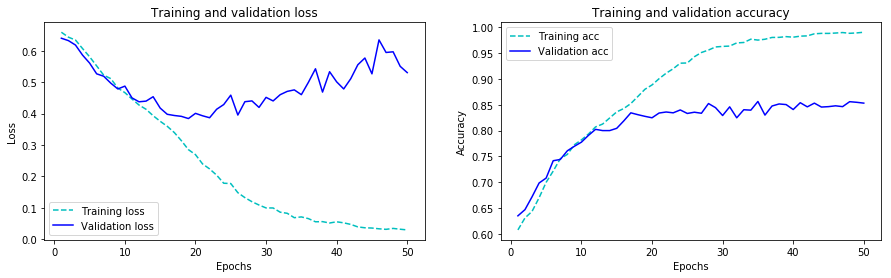

In [74]:
history10 = cnn3_imp_5.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history10)

In [75]:
evaluation_report(cnn3_imp_5,X_test,y_test)

[[955 170]
 [145 980]]
             precision    recall  f1-score   support

          0       0.87      0.85      0.86      1125
          1       0.85      0.87      0.86      1125

avg / total       0.86      0.86      0.86      2250

Loss: 0.4982794155544705 Accuracy: 0.8600000000529819


array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 50s 2ms/step - loss: 0.7132 - acc: 0.5319 - val_loss: 0.6711 - val_acc: 0.5964
Epoch 2/50
20250/20250 [==============================] - 49s 2ms/step - loss: 0.6705 - acc: 0.5896 - val_loss: 0.6652 - val_acc: 0.5896
Epoch 3/50
20250/20250 [==============================] - 50s 2ms/step - loss: 0.6610 - acc: 0.6034 - val_loss: 0.6435 - val_acc: 0.6304
Epoch 4/50
20250/20250 [==============================] - 51s 3ms/step - loss: 0.6458 - acc: 0.6294 - val_loss: 0.6354 - val_acc: 0.6356
Epoch 5/50
20250/20250 [==============================] - 51s 3ms/step - loss: 0.6391 - acc: 0.6401 - val_loss: 0.6180 - val_acc: 0.6708
Epoch 6/50
20250/20250 [==============================] - 51s 3ms/step - loss: 0.6262 - acc: 0.6523 - val_loss: 0.6361 - val_acc: 0.6200
Epoch 7/50
20250/20250 [==============================] - 51s 3ms/step - loss: 0.6095 - acc: 0.6710 - val_loss: 0.5699 - val_acc:

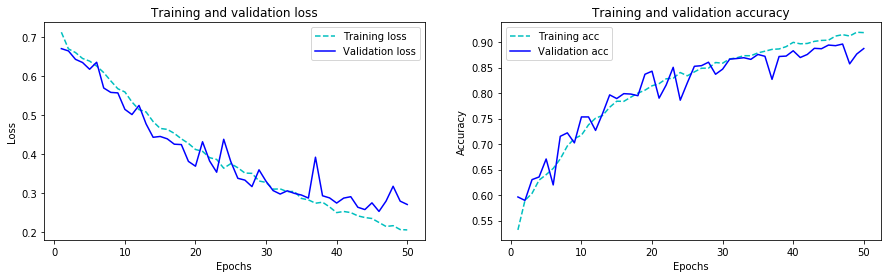

In [87]:
history11 = cnn3_imp_6.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history11)

In [88]:
evaluation_report(cnn3_imp_6,X_test,y_test)

[[ 898  227]
 [  52 1073]]
             precision    recall  f1-score   support

          0       0.95      0.80      0.87      1125
          1       0.83      0.95      0.88      1125

avg / total       0.89      0.88      0.88      2250

Loss: 0.2905861183007558 Accuracy: 0.8759999998940362


array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 29s 1ms/step - loss: 0.7173 - acc: 0.5017 - val_loss: 0.6916 - val_acc: 0.5000
Epoch 2/50
20250/20250 [==============================] - 28s 1ms/step - loss: 0.6913 - acc: 0.5272 - val_loss: 0.6882 - val_acc: 0.5508
Epoch 3/50
20250/20250 [==============================] - 28s 1ms/step - loss: 0.6874 - acc: 0.5455 - val_loss: 0.6840 - val_acc: 0.5400
Epoch 4/50
20250/20250 [==============================] - 28s 1ms/step - loss: 0.6814 - acc: 0.5646 - val_loss: 0.6722 - val_acc: 0.5852
Epoch 5/50
20250/20250 [==============================] - 27s 1ms/step - loss: 0.6745 - acc: 0.5795 - val_loss: 0.6640 - val_acc: 0.6064
Epoch 6/50
20250/20250 [==============================] - 27s 1ms/step - loss: 0.6717 - acc: 0.5830 - val_loss: 0.6539 - val_acc: 0.6096
Epoch 7/50
20250/20250 [==============================] - 27s 1ms/step - loss: 0.6619 - acc: 0.6037 - val_loss: 0.6583 - val_acc:

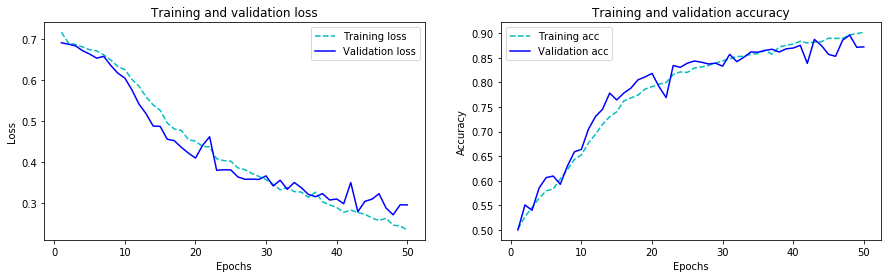

In [90]:
history12 = cnn3_imp_7.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val))
show_result(history12)

In [91]:
evaluation_report(cnn3_imp_7,X_test,y_test)

[[ 883  242]
 [  56 1069]]
             precision    recall  f1-score   support

          0       0.94      0.78      0.86      1125
          1       0.82      0.95      0.88      1125

avg / total       0.88      0.87      0.87      2250

Loss: 0.29239701795578005 Accuracy: 0.8675555556085375


array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

Train on 20250 samples, validate on 2500 samples
Epoch 1/50
20250/20250 [==============================] - 44s 2ms/step - loss: 0.7104 - acc: 0.5240 - val_loss: 0.6861 - val_acc: 0.5340
Epoch 2/50
20250/20250 [==============================] - 41s 2ms/step - loss: 0.6827 - acc: 0.5654 - val_loss: 0.6667 - val_acc: 0.6008
Epoch 3/50
20250/20250 [==============================] - 41s 2ms/step - loss: 0.6685 - acc: 0.5916 - val_loss: 0.6563 - val_acc: 0.6156
Epoch 4/50
20250/20250 [==============================] - 41s 2ms/step - loss: 0.6544 - acc: 0.6186 - val_loss: 0.6293 - val_acc: 0.6632
Epoch 5/50
20250/20250 [==============================] - 41s 2ms/step - loss: 0.6213 - acc: 0.6586 - val_loss: 0.6058 - val_acc: 0.6528
Epoch 6/50
20250/20250 [==============================] - 42s 2ms/step - loss: 0.5761 - acc: 0.7011 - val_loss: 0.5678 - val_acc: 0.6912
Epoch 7/50
20250/20250 [==============================] - 42s 2ms/step - loss: 0.5453 - acc: 0.7254 - val_loss: 0.4975 - val_acc:

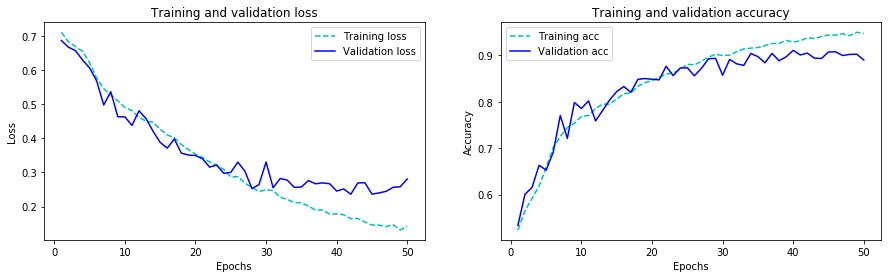

In [93]:
history13 = cnn3_imp_4_1.fit(X_train,y_train,batch_size=64,epochs=50,validation_data=(X_val,y_val))
show_result(history13)

In [94]:
evaluation_report(cnn3_imp_4_1,X_test,y_test)

[[ 903  222]
 [  31 1094]]
             precision    recall  f1-score   support

          0       0.97      0.80      0.88      1125
          1       0.83      0.97      0.90      1125

avg / total       0.90      0.89      0.89      2250

Loss: 0.28007185339927676 Accuracy: 0.8875555556085375


array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

### Try to use data augmentation

In [20]:
IMG_WIDTH, IMG_HEIGHT = 150, 150
TRAIN_DATA_DIR = 'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/data_test/training'
VALIDATION_DATA_DIR = 'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/data_test/validation'
TEST_DATA_DIR = 'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/data_test/testing'
TEST =  'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/data_test/test'
NB_TRAIN_SAMPLES = 2000
NB_VALIDATION_SAMPLES = 800
NB_EPOCH = 50

In [21]:
Train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [22]:
Val_datagen = image.ImageDataGenerator(rescale=1./255)

In [23]:
Train_generator = Train_datagen.flow_from_directory(
        TRAIN_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=32,
        class_mode='categorical')

Found 18000 images belonging to 2 classes.


In [29]:
valid_array = []
VALID_DIR = 'C:/Users/Nz-zero/Desktop/AI/lecture 5/Lab5_CNN/data_test/valid'
valid_images = [VALID_DIR +i for i in os.listdir(VALID_DIR )]
for img in os.listdir(VALID_DIR):
        path_r = os.path.join(VALID_DIR ,img)
        valid_array.append(cv2.resize((cv2.imread(path_r)),
                                 (IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_CUBIC).astype(float))
                        
X_valid =  np.array(valid_array)
y_valid = prepare_data(valid_images)

In [30]:
X_valid.shape

(2000, 150, 150, 3)

In [31]:
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],3)

In [32]:
(X_valid,y_valid)

(array([[[[ 87., 164., 203.],
          [ 92., 169., 208.],
          [ 93., 170., 209.],
          ...,
          [124., 206., 247.],
          [118., 203., 245.],
          [122., 201., 240.]],
 
         [[ 87., 164., 203.],
          [ 92., 169., 208.],
          [ 93., 170., 209.],
          ...,
          [124., 207., 245.],
          [122., 204., 245.],
          [122., 201., 240.]],
 
         [[ 87., 164., 203.],
          [ 92., 169., 208.],
          [ 93., 170., 209.],
          ...,
          [127., 209., 247.],
          [124., 206., 245.],
          [124., 203., 242.]],
 
         ...,
 
         [[ 54., 124., 157.],
          [ 55., 125., 158.],
          [ 56., 126., 159.],
          ...,
          [  0.,   4.,   3.],
          [  0.,   4.,   3.],
          [  0.,   2.,   2.]],
 
         [[ 56., 123., 154.],
          [ 57., 124., 155.],
          [ 60., 127., 158.],
          ...,
          [  0.,   2.,   2.],
          [  0.,   2.,   2.],
          [  0.,   2.,   2.

In [240]:
cnn3_imp_aug = models.Sequential()

cnn3_imp_aug.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                input_shape=(IMG_WIDTH,IMG_HEIGHT,3,),
                name = 'conv_1'))
cnn3_imp_aug.add(layers.Conv2D(filters=32,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_2'))
cnn3_imp_aug.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

cnn3_imp_aug.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_3'))
cnn3_imp_aug.add(layers.Conv2D(filters=64,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_4'))
cnn3_imp_aug.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

cnn3_imp_aug.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_5'))
cnn3_imp_aug.add(layers.Conv2D(filters=128,
                kernel_size=3,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name = 'conv_6'))
cnn3_imp_aug.add(layers.MaxPooling2D(2,2,name='max_pool_3'))

cnn3_imp_aug.add(layers.Dropout(0.7,name='dropout_1'))
cnn3_imp_aug.add(layers.Flatten())
cnn3_imp_aug.add(layers.Dense(256,activation='sigmoid',
              kernel_initializer='he_normal',
              name='fully_connect_1'))
cnn3_imp_aug.add(layers.Dropout(0.8,name='dropout_2'))

cnn3_imp_aug.add(layers.Dense(2,activation='softmax',
              kernel_initializer='he_normal',
              name='output'))

cnn3_imp_aug.compile(loss='categorical_crossentropy',
        optimizer=SGD(lr=0.01, momentum=0.9),
        metrics=['acc'])
cnn3_imp_aug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 75, 75, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 75, 75, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 37, 37, 64)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 37, 37, 128)       73856     
__________

### ------------------------------------------------

In [ ]:
from keras import regularizers

def cnn_with_regularizer(reg = None, model_file_name = 'reg_model.h5'):
    #cnn model 3
    from keras import regularizers

def cnn_with_regularizer(reg = None, model_file_name = 'reg_model.h5'):
    #cnn model 3
    cnn = models.Sequential()

    cnn.add(layers.Conv2D(filters=32,
                    kernel_size=3,
                    padding='same',
                    activation="relu",
                    kernel_initializer='he_normal',
                    input_shape=(IMG_SIZE,IMG_SIZE,1,),
                    name = 'conv_1'))
    cnn.add(layers.Conv2D(filters=32,
                    kernel_size=3,
                    padding='same',
                    activation="relu",
                    kernel_initializer='he_normal',
                    name = 'conv_2'))
    cnn.add(layers.MaxPooling2D(2,2,name='max_pool_1'))

    cnn.add(layers.Conv2D(filters=64,
                    kernel_size=3,
                    padding='same',
                    activation="relu",
                    kernel_initializer='he_normal',
                    name = 'conv_3'))
    cnn.add(layers.Conv2D(filters=64,
                    kernel_size=3,
                    padding='same',
                    activation="relu",
                    kernel_initializer='he_normal',
                    name = 'conv_4'))
    cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))

    cnn.add(layers.Conv2D(filters=128,
                    kernel_size=3,
                    padding='same',
                    activation="relu",
                    kernel_initializer='he_normal',
                    name = 'conv_5'))
    cnn.add(layers.Conv2D(filters=128,
                    kernel_size=3,
                    padding='same',
                    activation="relu",
                    kernel_initializer='he_normal',
                    name = 'conv_6'))
    cnn.add(layers.MaxPooling2D(2,2,name='max_pool_3'))


    cnn.add(layers.Dropout(0.5,name='dropout_1'))
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(256,activation='relu',
                  kernel_initializer='he_normal',
                  activity_regularizer = reg,
                  name='fully_connect_1'))
    cnn.add(layers.Dropout(0.8,name='dropout_2'))
    cnn.add(layers.Dense(2,activation='softmax',
                  kernel_initializer='he_normal',
                  name='output'))

    cnn.compile(optimizer='adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['acc']
               )
    cnn.summary()
    
    return cnn

# using regularizer
but it doesn't work well

In [ ]:
#using l1 regularize
cnn_4_l2 = cnn_with_regularizer(reg = regularizers.l2(0.01), model_file_name = 'l2_cnn4.h5')

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0)
]
history_2_l2 = cnn_4_l2.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_val,y_val))
show_result(history_2_l2)